# Brax Environments

Brax provides [Gym](https://gym.openai.com/)-like environments for training policies.  Just as in Gym, Brax environments have step and reset functions that return agent observations and rewards.  Let's try some out!

In [3]:
#@title Import Brax and some helper modules

import functools
import time

from IPython.display import HTML, Image 
import gym

try:
  import brax
except ImportError:
  from IPython.display import clear_output 
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

from brax import envs
from brax import jumpy as jp
from brax.envs import to_torch
from brax.io import html
from brax.io import image
import jax
from jax import numpy as jnp
import torch
v = torch.ones(1, device='cuda')  # init torch cuda before jax

In [Brax Basics](https://colab.research.google.com/github/google/brax/blob/main/notebooks/basics.ipynb) we tried out a few simple physics systems.  In order to train agents to achieve some behavior within these systems, we define an environment: a physics system, a way for the agent to observe the system, and a reward function that defines some objective.  Brax comes with many built-in environments in order to get started quickly.

## OpenAI Gym Environments

**[ant](https://github.com/google/brax/blob/main/brax/envs/ant.py)** from [OpenAI Gym Ant-v2](https://gym.openai.com/envs/Ant-v2/): make a four-legged creature walk forward as fast as possible

**[halfcheetah](https://github.com/google/brax/blob/main/brax/envs/halfcheetah.py)** from [OpenAI Gym HalfCheetah-v2](https://gym.openai.com/envs/HalfCheetah-v2/): make a two-dimensional two-legged creature walk forward as fast as possible

**[hopper](https://github.com/google/brax/blob/main/brax/envs/hopper.py)** from [OpenAI Gym Hopper-v2](https://gym.openai.com/envs/Hopper-v2/): make a two-dimensional one-legged robot hop forward as fast as possible

**[humanoid](https://github.com/google/brax/blob/main/brax/envs/humanoid.py)** from [OpenAI Gym Humanoid-v2](https://gym.openai.com/envs/Humanoid-v2/): make a three-dimensional bipedal robot walk forward as fast as possible, without falling over.

**[reacher](https://github.com/google/brax/blob/main/brax/envs/reacher.py)**: from [OpenAI Gym Reacher-v2](https://gym.openai.com/envs/Reacher-v2/): makes a two-joint reacher arm move its tip to a target.

**[walker2d](https://github.com/google/brax/blob/main/brax/envs/walker2d.py)** from [OpenAI Gym Walker2d-v2](https://gym.openai.com/envs/Walker2d-v2/): make a two-dimensional bipedal robot walk forward as fast as possible

## Custom Environments

**[fetch](https://github.com/google/brax/blob/main/brax/envs/fetch.py)**: make a three-dimensional dog chase after a moving target.

**[grasp](https://github.com/google/brax/blob/main/brax/envs/grasp.py)**: a grabber hand must pick up a ball and carry it to a moving target.

**[ur5e](https://github.com/google/brax/blob/main/brax/envs/ur5e.py)**: a ur5e robot arm that moves its end effector to a series of targets.



In [4]:
#@title Visualizing pre-included Brax environments { run: "auto" }
#@markdown Select an environment to preview it below:

environment = "ant"  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'reacher', 'walker2d', 'fetch', 'grasp', 'ur5e']
env = envs.create(env_name=environment)
state = env.reset(rng=jp.random_prngkey(seed=0))

HTML(html.render(env.sys, [state.qp]))

# Stepping and Jitting Environments

We operate environments via `env.step`:

$$
\text{state}_{t+1} = \text{env.step}(\text{state}_t, \text{action})
$$


The state returned by `env.step` contains:
* the physics state `QP`
* the observation vector
* reward
* whether the environment is done and needs to be reset
* other useful metrics.

By calling `env.step` in sequence we produce a rollout:

In [5]:
%%time
rollout = []
for i in range(100):
  # wiggle sinusoidally with a phase shift per actuator
  action = jp.sin(i * jp.pi / 15 + jp.arange(0, env.action_size) * jp.pi)
  state = env.step(state, action)
  rollout.append(state)

CPU times: user 17.1 s, sys: 0 ns, total: 17.1 s
Wall time: 17.1 s


In order to train policies quickly, we use [JAX](https://github.com/google/jax) to jit compile the `env.step`: 

In [6]:
# jit compile env.step:
jit_env_step = jax.jit(env.step)
state = jit_env_step(state, jnp.ones((env.action_size,)))

After `env.step` has been compiled, it runs much faster:

In [7]:
%%time
for _ in range(100):
  state = jit_env_step(state, jnp.ones((env.action_size,)))

CPU times: user 7.08 s, sys: 0 ns, total: 7.08 s
Wall time: 3.69 s


# Visualizing Rollouts

Brax provides two handy ways to visualize environment rollouts.  The first is an HTML visualizer:

In [9]:
HTML(html.render(env.sys, [s.qp for s in rollout]))

The second is an image visualizer that produces animated GIFs or PNGs:

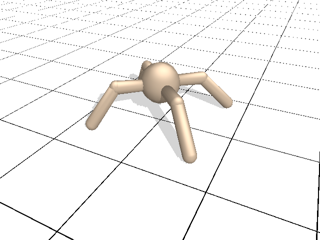

In [10]:
Image(image.render(env.sys, [s.qp for s in rollout], width=320, height=240))

# OpenAI Gym Wrapper + PyTorch

Brax environments can converted to Gym environments, using either [GymWrapper](https://github.com/google/brax/blob/main/brax/envs/wrappers.py) for single environments, or [VectorGymWrapper](https://github.com/google/brax/blob/main/brax/envs/wrappers.py) for batched (parallelized) environments.  Gym-wrapped Brax environments are jit-compiled, and can interoperate with (and share accelerator resources with) other learning frameworks such as PyTorch.

In [ ]:
entry_point = functools.partial(envs.create_gym_env, env_name='ant')
if 'brax-ant-v0' not in gym.envs.registry.env_specs:
  gym.register('brax-ant-v0', entry_point=entry_point)

# create a gym environment that contains 4096 parallel ant environments
gym_env = gym.make("brax-ant-v0", batch_size=4096)

# wrap it to interoperate with torch data structures
gym_env = to_torch.JaxToTorchWrapper(gym_env, device='cuda')

# jit compile env.reset
obs = gym_env.reset()

# jit compile env.step
action = torch.rand(gym_env.action_space.shape, device='cuda') * 2 - 1
obs, reward, done, info = gym_env.step(action)

Here, we generate a rollout using our Gym wrapper with PyTorch data:

In [ ]:
before = time.time()

for _ in range(100):
  action = torch.rand(gym_env.action_space.shape, device='cuda') * 2 - 1
  obs, rewards, done, info = gym_env.step(action)

duration = time.time() - before
print(f'time for {409600} steps: {duration:.2f}s ({int(409600 / duration)} steps/sec)')

time for 409600 steps: 0.46s (895723 steps/sec)


Ciao! 👋